<a href="https://www.kaggle.com/code/reikaf/case-study-of-e-commerce-demand-forecasting?scriptVersionId=91588818" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A simple case study of demand forecasting with an e-commerce dataset
---
A simple case study of e-commerce demand forecasting with an open-source e-commerce dataset from Olist. 
1. [Data Collection](#data_collection) 
2. [Exploratory Data Analysis](#eda) 
    - [Demand history](#eda_1)
    - [Purchase frequency by items](#eda_2)
    - [Comparison of the sales history in different categories](#eda_3)
    - [Preparations for modeling](#eda_4)
3. [Demand Forecast Modeling](#modeling)
4. [Evaluation](#evaluation)
    - [Model decay](#evaluation_1)
    - [Demand forecasting curve](#evaluation_2)
    - [Learning curves](#evaluation_3)
    - [Feature importances](#evaluation_4)
    - [Price elasticity of demand](#evaluation_5)
5. [Conclusion](#conclusion)

## Purpose 
---
Setting the right prices for products has been an essential problem for long years. <br>

Conventionally, companies have applied their own pricing strategies which considerably vary from one company to another. These strategies often rely on heuristics solutions based on their own experiences and knowledge. As widely known, however, they are not the best solutions in general. <br>

Recently, price optimization has been gaining popularity among pricing strategies. Price optimization utilizes machine-learning methods to forecast demand and finds the best prices for various problems. For example, price optimization often uses such features as competition, weather, season, special events or holidays, macroeconomic variables, operating costs, and warehouse information in order to determine the initial price, the best price, the discount price, and the promotional price. Price optimization has a potential of producing large profits in retails and B2B markets. In particular, it can be a powerful solution in e-commerce business, where customers are used to frequent price changes: real-time price optimization is critical because demand changes dramatically in a very short time span. <br>

Nonetheless, price optimization is still a challenging issue. Demand can change substantially due to various factors in the world, and it is often difficult to forecast the demand accurately and set the right prices.
<br>

In this notebook, a very simple case study of demand forecasting, which is an essential part of price optimization, will be shared. In the [first section](#data_collection), the dataset based on the [open-source data on Kaggle provided by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?datasetId=55151&sortBy=voteCount&select=olist_order_payments_dataset.csv) is described. The [second section](#eda) is devoted to the exploratory data analysis, where the trend of demand (purchase history) is discussed. Based on the analyses in section 2, a demand-forecast model is built in [section 3](#modeling). The model is evaluated in [section 4](#evaluation) and conclusions are shown in [section 5](#conclusion).<br>
Altough long-term forecasting models or models that are valid for a long period are more preferable because of the computational cost in real situations, in this work a model is trained for each day. This is because it turned out that the accuracy of a model rapidly decreases over time. This means the demand trend is very sensitive to latest information, which even requires changes of the model itself. Further details are discussed in section 4.
<br>
<br>
I appriciate any comments, questions, and suggestions.<br><br>

#### Acknowledgements
Throughout this work, I refer to these great articles about the introduction of price optimization by tryolabs.
- [Price optimization for e-commerce: a case study](https://tryolabs.com/blog/price-optimization-machine-learning)
- [How Machine Learning is reshaping Price Optimization](https://tryolabs.com/blog/2020/06/01/price-optimization-for-e-commerce-a-case-study)



## Data Collection<a name="data_collection"></a>
---
[Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)
provides multiple datasets related to Olist's order history from 2016 to 2018 in the following data schema (cited by the Kaggle page). <br><br>

<center><img src="https://i.imgur.com/HRhd2Y0.png" width="550", align="center"/></center>

<br><br>
In this work, order history, payment (price) data, and product details are of interest for the purpose of demand forecasting. Therefore, the datasets to be used are the olist_orders, olist_order_items, and olist_products_dataset. <br>
At this time I ignore the olist_items and leave it for a future exploration, which contains detailed information about items (size, picture, and reviews from customers). Further feature engineering and integrations of these data can improve the performance demand forecasting model.

### preparation

In [1]:
# import libraries
import datetime
import time
from pathlib import Path

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# import data
folder_path = '/kaggle/input/brazilian-ecommerce/'
df_orders = pd.read_csv(folder_path + 'olist_orders_dataset.csv')
df_order_items = pd.read_csv(folder_path + 'olist_order_items_dataset.csv')
df_products = pd.read_csv(folder_path + 'olist_products_dataset.csv')
df_product_category_name_translation = pd.read_csv(folder_path + 'product_category_name_translation.csv')

# extract the data we need
df_orders = df_orders[['order_id','order_purchase_timestamp']]
df_order_items = df_order_items[['order_id','product_id','price']]
df_products = df_products[['product_id','product_category_name']].merge(df_product_category_name_translation, how='left', on='product_category_name').drop(columns='product_category_name')

# merge datasets
df = df_order_items.merge(df_orders, how='left', on='order_id')
df = df.merge(df_products, how='left', on='product_id').drop(columns='order_id')
df = df.rename(columns={'product_category_name_english':'category',
                  'order_purchase_timestamp':'timestamp'})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   product_id  112650 non-null  object 
 1   price       112650 non-null  float64
 2   timestamp   112650 non-null  object 
 3   category    111023 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.3+ MB


## Exploratory Data Analysis<a name="eda"></a>
---
1. [Demand history](#eda_1)
2. [Purchase frequency by items](#eda_2)
3. [Comparison of the sales history in different categories](#eda_3)
4. [Preparations for modeling](#eda_4)

### 1. Demand history<a name="eda_1"></a>

<AxesSubplot:>

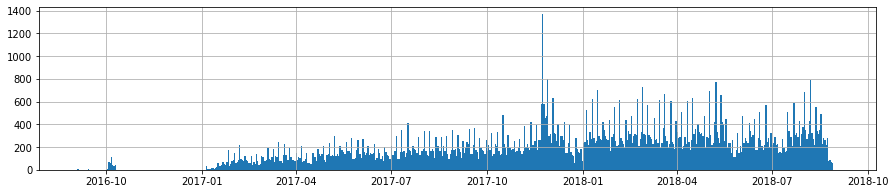

In [5]:
# daily plot
pd.to_datetime(df.timestamp).dt.date.hist(bins=593,figsize=(15,3))

<AxesSubplot:>

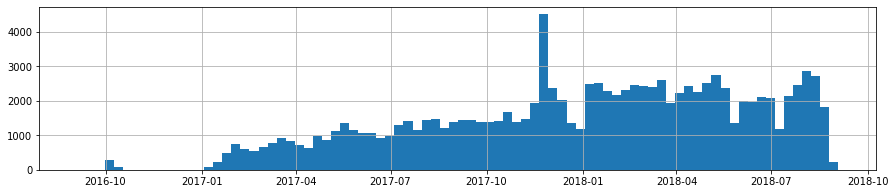

In [6]:
# weekly plot
pd.to_datetime(df.timestamp).dt.date.hist(bins=593//7,figsize=(15,3))

**Summary**
- The variance of daily demand is very high.
- As a whole, the number of sales has increased over time. 
- In the daily plot, a periodic (weekly) demand change is observed. (demand increases on weekends)
- There are many (apparently random) intense shifts. For example, it seems that the sales history has an unusual peak on Black Friday, suggesting that a specific event affects the purchase.

### 2. Purchase frequency by items<a name="eda_2"></a>
For each product, if there is not enough volume of purchase history, demand forecasting is difficult. Therefore, the trend of purchase frequency per product is inspected here.

<AxesSubplot:>

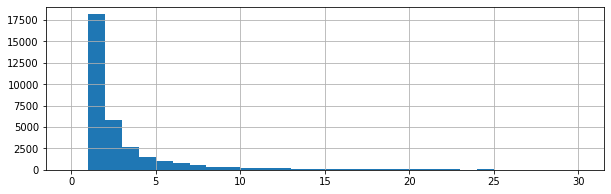

In [7]:
df.product_id.value_counts().hist(bins=30, range=(0, 30),figsize=(10,3))

**Summary**
- There are many items that have only 1 or a few purchase histories.

### 3. Comparison of the sales histories in different categories<a name="eda_3"></a>
Different categories might have different trends of purchase history. The number of unique items, the number of purchase volume, and the total sales price are plotted for popular categories. The purchase volume divided by the number of unique items is also plotted to grasp the average purchase trend of each item.

In [3]:
# group by categories
_tmp = df.groupby('category').product_id.count()
_tmp = _tmp[_tmp.apply(lambda x: x>200)].sort_values(ascending=False)
_categories = list(_tmp.index)

_tmp = df[df.category.apply(lambda x: x in _tmp.index)]
_tmp.loc[:,'year'] = pd.to_datetime(_tmp.timestamp).dt.year
_tmp.loc[:,'month'] = pd.to_datetime(_tmp.timestamp).dt.month
_tmp.loc[:,'year_month'] = pd.to_datetime(_tmp['year'].astype(str)+'-'+_tmp['month'].astype(str))
_hist_list = {}
for i in range(len(_categories)):
    _hist_list[_categories[i]] = _tmp[_tmp.category.apply(lambda x: x==_categories[i])]    

# calculate the number of unique items, total sales price, the number of sold items per month.
_hist_info = {}
for i in range(len(_categories)):
    _d = {}
    _d['nunique'] = _hist_list[_categories[i]].groupby('year_month').product_id.nunique()
    _d['price_sum'] = _hist_list[_categories[i]].groupby('year_month').price.sum()
    _d['count'] = _hist_list[_categories[i]].groupby('year_month').product_id.count()
    _hist_info[_categories[i]] = _d

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


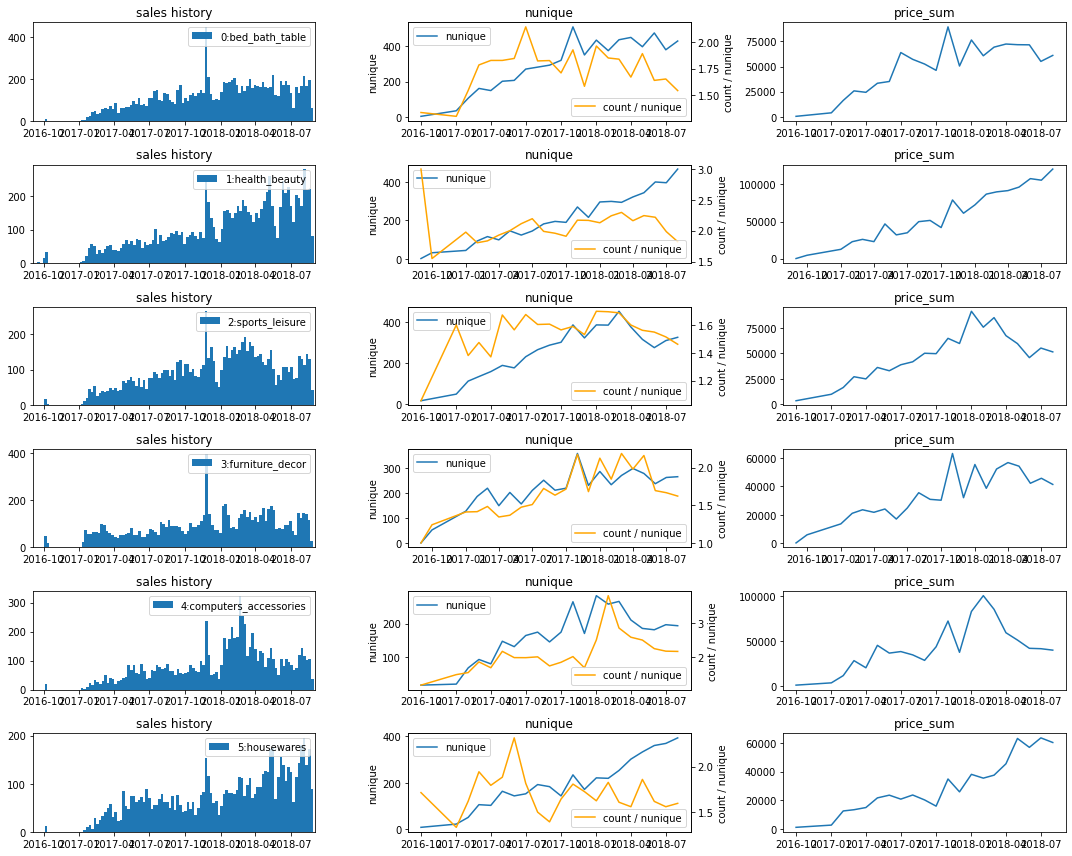

In [4]:
# n = len(_categories)
n = 6

fig = plt.figure(figsize=(15, 2*n))
axes = []
for i in range(n):
    axes.append(fig.add_subplot(n,3,3*i+1))
    axes[4*i].hist(pd.to_datetime(_hist_list[_categories[i]].timestamp).dt.date, bins=104,\
                label='{}:'.format(i)+_categories[i])
    axes[4*i].legend(loc = 'upper right')
    axes[4*i].set_xlim(pd.to_datetime(_tmp.timestamp.min()).date(), pd.to_datetime(_tmp.timestamp.max()).date())
    axes[4*i].title.set_text('sales history')
    
    axes.append(fig.add_subplot(n,3,3*i+2))
    axes.append(axes[4*i+1].twinx())
    axes.append(fig.add_subplot(n,3,3*i+3))
    x = pd.to_datetime(_hist_info[_categories[i]]['nunique'].index)
    y2_1 = _hist_info[_categories[i]]['nunique'].to_list()
    y2_2 = (_hist_info[_categories[i]]['count'] / _hist_info[_categories[i]]['nunique']).to_list()
    y3 = _hist_info[_categories[i]]['price_sum'].to_list()
    axes[4*i+1].plot(x,y2_1,color='tab:blue',label='nunique')
    axes[4*i+1].title.set_text('nunique')
    axes[4*i+1].set_ylabel('nunique')
    axes[4*i+1].legend(loc = 'upper left')
    axes[4*i+2].plot(x,y2_2,color='orange',label='count / nunique')
    axes[4*i+2].set_ylabel('count / nunique')
    axes[4*i+2].legend(loc = 'lower right')
    axes[4*i+3].plot(x,y3)
    axes[4*i+3].title.set_text('price_sum')

plt.tight_layout()
plt.show()

- In all categories, the number of items has increased over time.
- In all categories, the total sales price has increased over time.
- The plots suggest that there are several types in sales trends: 
    1. The sales price has grown because the number of items has grown (ex. health_beauty, bed_bath_table)
    2. The sales price has grown because both the number of items and the demand for each item has grown (ex. furniture_decor, watches gifts)

### 4. Preparations for modeling<a name="eda_4"></a>
To predict the demand for each item, items that do not have enough purchase history should be removed. Here we decided the minimum history as at least 1-unit purchase in the 10 weeks. 

In [5]:
# remove items which do not have enough sells history data (at least 1 sell unit in the 10 weeks. at least 'minimum_sells' unit sells.)
end_timestamp = df.timestamp.max()
minimum_sells = 10

def extract_applicable_items(values):
    l = list(values)
    if len(l) < minimum_sells:
        return False
    l.append(end_timestamp)
    l.sort()
    for i in range(len(l)-1):
        if pd.to_datetime(l[i+1]).date()-pd.to_datetime(l[i]).date() > datetime.timedelta(days=10*7):
            return False
    return True

_tmp = df.groupby('product_id').timestamp.apply(extract_applicable_items)
items = _tmp[_tmp].index.to_list()

# create new dataframe based on the extracted product ids.
df_new = df[df.product_id.apply(lambda x: x in items)].reset_index(drop=True)

print(len(df.product_id.unique()), len(items))

32951 443


The number of items has been reduced from 32951 to 441.

<AxesSubplot:>

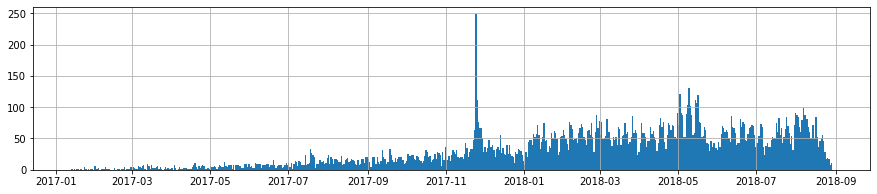

In [11]:
# visualization of the trend of total sales.
# daily
pd.to_datetime(df_new.timestamp).dt.date.hist(bins=593,figsize=(15,3))

<AxesSubplot:>

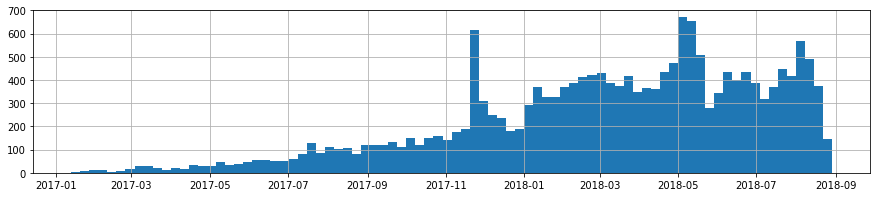

In [46]:
# visualization of the trend of total sales.
# weekly
pd.to_datetime(df_new.timestamp).dt.date.hist(bins=593//7,figsize=(15,3))

The trends seems to be consistent with the previous dataset before we remove the items with few purchase records.

## Demand Forecast Modeling<a name="modeling"></a>

- **Features**
    - features
        - item id 
        - seasonal information (year, month, week, day of week, day)
        - historical sales trend information (total sales in last 1 day, 3 days, 1 week, 1 month, 1 year)
        - Brazilian economical information
            - [Brazilian imports](https://tradingeconomics.com/brazil/imports)
            - [Brazilian customer confidence](https://tradingeconomics.com/brazil/consumer-confidence)
    - label
        - sales volume

- **Model training**
    - LightGBM model
    - For each target day, a model is trained using the past data, and makes a prediction on the target day.
        - ex.) To predict the sales volume on January 1st 2018, all the data between the start date and December 31th 2017 are used as a train dataset. After that, the model predicts the sales volume of January 1st 2018.
    - Repeat model training & prediction for each day to obtain demand forecasting curve.


### feature engineering
Create features
- In this notebook, we pick up 'computers_accessories' category as an example.
- create features
    - historical sales trend information (total sales in last 1 day, 3 days, 1 week, 1 month, 1 year)
    - Brazilian economical information 

In [6]:
# Group by categories
_tmp = df_new.groupby('category').product_id.count()
_tmp = _tmp[_tmp.apply(lambda x: x>200)].sort_values(ascending=False)
_categories = list(_tmp.index)

_tmp = df_new[df_new.category.apply(lambda x: x in _tmp.index)]
_tmp.loc[:,'year'] = pd.to_datetime(_tmp.timestamp).dt.year
_tmp.loc[:,'month'] = pd.to_datetime(_tmp.timestamp).dt.month
# _tmp.loc[:,'year_month'] = pd.to_datetime(_tmp['year'].astype(str)+'-'+_tmp['month'].astype(str))
_tmp.loc[:,'week'] = pd.to_datetime(_tmp.timestamp).dt.week
_tmp.loc[:,'date'] = pd.to_datetime(_tmp.timestamp).dt.date
_hist_list = {}
for i in range(len(_categories)):
    _hist_list[_categories[i]] = _tmp[_tmp.category.apply(lambda x: x==_categories[i])]    

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# Integrate Brazilian economy information
folder_path_brazil_economy = '/kaggle/input/brazil-economy/brazil_economy/'
df_customer_confidence = pd.read_csv(folder_path_brazil_economy + 'brazil_customer_confidence.csv')
df_brazil_imports = pd.read_csv(folder_path_brazil_economy + 'brazil_imports.csv')

# Here we pick up 'computers_accessories' category.
category_name = 'computers_accessories'

_df = _hist_list[category_name]
_df = _df.groupby(['product_id','date']).product_id.count()
_df = _df.to_frame(name='sales')
_df = _df.reset_index()  
start = datetime.date(2016,10,1)
end = datetime.date(2018,9,30) 
_df_left = pd.DataFrame()
_df_left['date'] = pd.date_range(start, end).strftime("%Y-%m-%d")
_df_left['date'] = pd.to_datetime(_df_left['date']).dt.date
_df_left['tmp'] = 1
_df_right = pd.DataFrame()
_df_right['product_id'] = _df.product_id.unique()
_df_right['tmp'] = 1
_df_left = pd.merge(_df_left, _df_right, on=['tmp'])
_df_left = _df_left.drop('tmp',axis=1)
_df = _df_left.merge(_df, on=['date','product_id'], how='left')
_df = _df_left.merge(_df, on=['date','product_id'], how='left').fillna(0)
_df['year'] = pd.to_datetime(_df.date).dt.year
_df['month'] = pd.to_datetime(_df.date).dt.month
_df['day'] = pd.to_datetime(_df.date).dt.day
_df['week'] = pd.to_datetime(_df.date).dt.week
_df['weekday'] = pd.to_datetime(_df.date).dt.day_name()
_df = _df.merge(df_customer_confidence, how='left', on=['year','month'])
_df = _df.merge(df_brazil_imports, how='left', on=['year','month'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
# add features (day from Black Friday, sales volume in last 1 day, 3 days, 1 week, 1 month, 3 monthes and 1 year)

def day_to_black_friday(month, day):
    month_bf = 11
    day_bf = 25
    if month_bf != month:
        return 100
    return day_bf - day

_df['day_to_bf'] = _df.apply(lambda x: day_to_black_friday(x.month, x.day), axis=1)
_df['date_day_lag'] = _df['date'] - datetime.timedelta(days=1)
_df['date_3day_lag'] = _df['date'] - datetime.timedelta(days=3)
_df['date_week_lag'] = _df['date'] - datetime.timedelta(weeks=1)
_df['date_month_lag'] = _df['date'] - datetime.timedelta(days=30)
_df['date_3month_lag'] = _df['date'] - datetime.timedelta(days=90)
_df['date_year_lag'] = _df['date'] - datetime.timedelta(days=365)

def total_sales(day1,day2):
    if day1 < _df.date.min():
        return -1
    tot = _df[_df.date.apply(lambda x: day1<=x and x<day2)].sales.mean()
    return tot

_df['sales_last_day'] = _df.apply(lambda x: total_sales(x.date_day_lag,x.date), axis=1)
_df['sales_last_3day'] = _df.apply(lambda x: total_sales(x.date_3day_lag,x.date), axis=1)
_df['sales_last_week'] = _df.apply(lambda x: total_sales(x.date_week_lag,x.date), axis=1)
_df['sales_last_month'] = _df.apply(lambda x: total_sales(x.date_month_lag,x.date), axis=1)
_df['sales_last_3month'] = _df.apply(lambda x: total_sales(x.date_3month_lag,x.date), axis=1)
_df['sales_last_year'] = _df.apply(lambda x: total_sales(x.date_year_lag,x.date), axis=1)

_df = _df.drop(columns=['date_day_lag','date_3day_lag','date_week_lag','date_month_lag','date_3month_lag','date_year_lag'])

In [34]:
# add price information
_tmp_price = _hist_list[category_name]
_tmp_price = _tmp_price.groupby(['product_id','date','price']).product_id.count()
_tmp_price = _tmp_price.to_frame(name='sales')
_tmp_price = _tmp_price.reset_index()  
_tmp_price = _tmp_price.drop('sales',axis=1)

_df = _df.merge(_tmp_price, how='left', on=['product_id','date'])

_df_by_product_id = []
for product_id in _df.product_id.unique():
    _tmp = _df[_df.product_id==product_id]
    _tmp = _tmp.sort_values(by='date')
    _tmp['price'] = _tmp.price.interpolate(limit_direction='both')
    _df_by_product_id.append(_tmp)
    
df = pd.DataFrame()
for i in range(len(_df_by_product_id)):
    df = pd.concat([_df_by_product_id[i],df], axis=0)

df = df.sort_values(by='date').reset_index(drop=True)

df.to_csv('feature.csv',index=False)

df.head()

,date,product_id,sales,year,month,day,week,weekday,CC,imports,day_to_bf,sales_last_day,sales_last_3day,sales_last_week,sales_last_month,sales_last_3month,sales_last_year,price
0,2016-10-01,efa490145b5cc82438b6a6de691535fa,0.0,2016,10,1,39,Saturday,41.8,11518.693,100,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46.99
1,2016-10-01,06f2166336faca73c644b11eaca22d06,0.0,2016,10,1,39,Saturday,41.8,11518.693,100,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,105.00
2,2016-10-01,e6fd80a00ebb1a3e0d58a38555fbbf2c,0.0,2016,10,1,39,Saturday,41.8,11518.693,100,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,22.99
3,2016-10-01,08a58dc963320d6073623382b9ceb920,0.0,2016,10,1,39,Saturday,41.8,11518.693,100,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,129.00
4,2016-10-01,e5ae72c62ebfa708624f5029d609b160,0.0,2016,10,1,39,Saturday,41.8,11518.693,100,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,61.90


### Modeling
- For each target day, a LightGBM model is trained.
- Repeat model training & prediction for each day to obtain a demand forecasting curve.
- Long-term prodection is also conducted for comparison.

In [13]:
# if this is not the first time, skip feature engineering and load dataset.
path_feature = Path("feature.csv")
if path_feature.is_file():
    df = pd.read_csv(path_feature)

In [ ]:
# parameters
df['product_id'] = df.product_id.astype('category')
df['year'] = df.year.astype('category')
df['weekday'] = df.weekday.astype('category')
label = 'sales'
feature_cols = ['product_id','year','month','week','day','weekday','CC','imports','day_to_bf',\
                'sales_last_day','sales_last_3day','sales_last_week','sales_last_month','sales_last_3month','sales_last_year','price']
categorical_cols = ['product_id','year','weekday']

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2','auc','rmse'],
    'num_leaves': 31,
    'learning_rate': 0.04,
    'num_iterations':100,
#     'max_depth':4,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2':0.2,
    'verbose': 0,
    'force_row_wise':True
}
num_round = 100
evaluation_results = {}       

In [ ]:
# model training & prediction
start = datetime.date(2016,10,1)
end = datetime.date(2018,9,30) 
eval_date = datetime.date(2018,3,1) 
preds = {}
errors = pd.DataFrame()
pred_sum = {}
test_sum = {}
calc_error = True
df_once = {}

for date in pd.date_range(start + datetime.timedelta(days=365), end):
    date = date.date()
    X_train = df[df['date']<date].drop(['sales','date'],axis=1)
    y_train = df[df['date']<date]['sales']
    X_test = df[df['date']==date].drop(['sales','date'],axis=1)
    y_test = df[df['date']==date]['sales']
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    lgb_train = lgb.Dataset(X_train,
                            label=y_train,
                            categorical_feature=categorical_cols,
                            free_raw_data=False)
    lgb_val = lgb.Dataset(X_val,
                          label=y_val,
                          categorical_feature=categorical_cols,
                          free_raw_data=False)
    lgb_test = lgb.Dataset(X_test,
                          label=y_test,
                          categorical_feature=categorical_cols,
                          free_raw_data=False)
    if date == eval_date:
        model = lgb.train(params,
                          lgb_train,
                          num_boost_round=num_round,
                          valid_names=['train', 'valid'], 
                          valid_sets=[lgb_train, lgb_val],
                          evals_result=evaluation_results,
                          early_stopping_rounds=30,
                          verbose_eval=-1)
        model.save_model('model.txt')
    else:
        model = lgb.train(params,
                  lgb_train,
                  num_boost_round=num_round,
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_val],
                  early_stopping_rounds=30,
                  verbose_eval=-1)
    df_pred = X_test[['product_id']].copy()
    df_pred['y_test'] = y_test
    df_pred['y_pred'] = model.predict(X_test)
    preds[date] = df_pred
    test_sum[date] = df_pred['y_test'].sum()
    pred_sum[date] = df_pred['y_pred'].sum()
    
    if calc_error:
        _end = date+datetime.timedelta(days=30)
        if _end <= end:
            X_test = df[(df['date']>=date) & (df['date']<=_end)].drop(['sales'],axis=1)
            y_test = df[(df['date']>=date) & (df['date']<=_end)]['sales']
            _tmp = X_test[['date']].copy()
            _tmp['y_test'] = y_test
            _tmp['y_pred'] = model.predict(X_test.drop('date',axis=1))
            df_error = _tmp.groupby('date').sum().reset_index()
            df_error['{}'.format(date)] = df_error.apply(lambda x: (x.y_test-x.y_pred)**2, axis=1)
            if len(errors)==len(df_error):
                errors = pd.concat([df_error[['{}'.format(date)]],errors],axis=1)
            else: 
                errors['{}'.format(date)] = df_error['{}'.format(date)]
            if date == eval_date:
                df_once['{}'.format(date)] = _tmp.groupby('date').sum().reset_index()

## Evaluation<a name="evaluation"></a>

### 1. Model decay<a name="evaluation_1"></a>
1. Visualize how fast the performance of a model decays.

<AxesSubplot:title={'center':'mean squared error'}, xlabel='days', ylabel='MSE'>

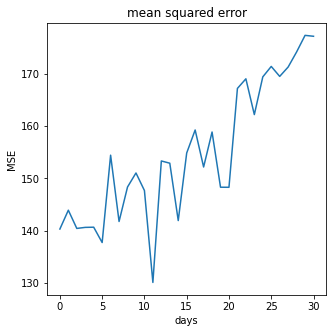

In [48]:
errors['mse'] = errors.sum(axis=1).apply(lambda x: np.sqrt(x))
errors.mse.plot(figsize=(5,5),title='mean squared error',xlabel='days',ylabel='MSE')

The mean squared error decays over time. <br><br>

2. Compare the demand forecasting curves of 30 days to the actual demand curve.
    - We compare two different demand forecasting curves to understand the model decay.
        1. Demand forecasting where models are retrained to make predictions each day. ("retrained")
        2. Demand forecasting where a model is trained only once and used for all predictions for the following 30 days. ("once")

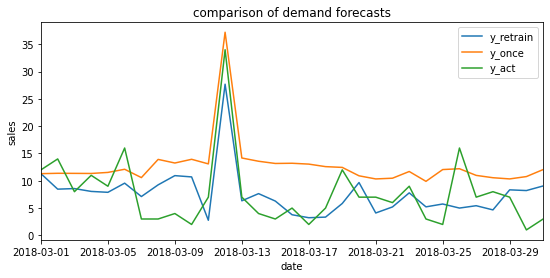

In [42]:
x = []
y_act = []
y_retrain = []
y_once = df_once['{}'.format(eval_date)]['y_pred'].to_list()
y_act = df_once['{}'.format(eval_date)]['y_test'].to_list()

for date in pd.date_range(eval_date, eval_date + datetime.timedelta(days=30)):
    date = date.date()
    x.append(date)
    y_retrain.append(pred_sum[date])

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y_retrain, label='y_retrain')
ax.plot(x, y_once, label='y_once')
ax.plot(x, y_act, label='y_act')
ax.set_xlim(eval_date, date)
ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.legend()
ax.title.set_text('comparison of demand forecasts')
plt.savefig('demand_forecast.jpg')
plt.show()

Compared to y_once (a model is trained only once and used for all the predictions for the following 30 days), y_retrain (models are retrained every day) is more successful in predicting the fluctuations especially after the first 10 days. This means the demand trend is very sensitive to latest information, which even requires changes of the model itself. <br><br>


### 2. Demand forecasting curve<a name="evaluation_2"></a>
1. Visualize demand forecasting (for one specific item) and the price.

product_id: e53e557d5a159f5aa2c5e995dfdf244b


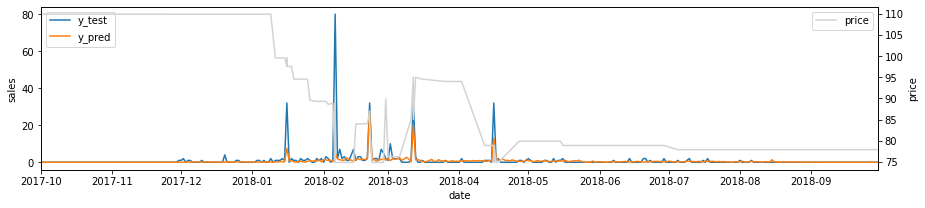

In [118]:
# prepare for data visualization. 
_items = df.product_id.value_counts().keys()[:10]

i = 0
l_dates = []
l_test_sum = []
l_pred_sum = []

for j in range(len(list(test_sum.keys()))):
    l_dates.append(list(test_sum.keys())[j])
    _tmp = preds[list(test_sum.keys())[j]]
    _tmp = _tmp[_tmp.product_id==_items[i]]
    l_test_sum.append(_tmp.y_test.sum())
    l_pred_sum.append(_tmp.y_pred.sum())
    
# visualize the demand forecast for a specific item.
print('product_id:',_items[i])

x = df[df.product_id == _items[i]]['date'].to_list()
y = df[df.product_id == _items[i]]['price'].to_list()

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1)
ax.plot(l_dates, l_test_sum, label='y_test')
ax.plot(l_dates, l_pred_sum, label='y_pred')
ax.set_xlim(start + datetime.timedelta(days=365), end)
ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.legend(loc='upper left')
ax_ = ax.twinx()
ax_.plot(x, y, label='price', color='lightgray')
ax_.set_ylabel('price')
ax_.legend(loc='upper right')
plt.savefig('demand_forecast_{}.jpg'.format(_items[i]))
plt.show()

For some of the large peaks, the model is successful in predicting them while it fails to predict some other large peaks (ex. the one in the beginning of February 2018) and small fluctuations.<br><br>

2. Visualize demand forecasting (average of all the items in the "computer accessory" category)

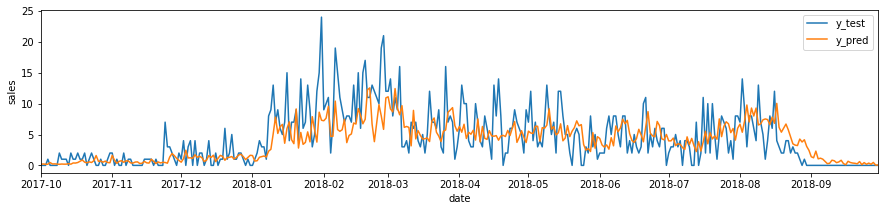

In [37]:
# visualize the demand forecast as a whole.
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1)
ax.plot(test_sum.keys(), test_sum.values(), label='y_test')
ax.plot(pred_sum.keys(), pred_sum.values(), label='y_pred')
ax.set_xlim(start + datetime.timedelta(days=365), end)
ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.legend()
plt.savefig('demand_forecast.jpg')
plt.show()

The model predicts some trends as a whole, but doesn't predict fluctuations.<br><br>

### 3. Learning curves<a name="evaluation_3"></a>
- Visualization of the learning curves.

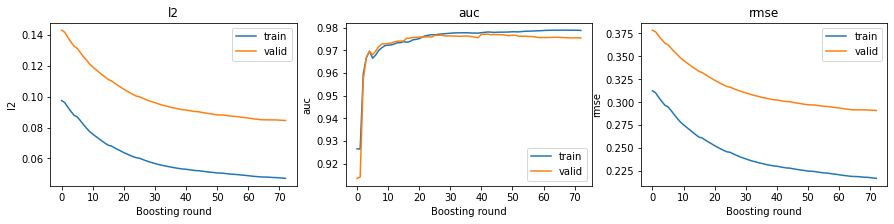

In [38]:
fig = plt.figure(figsize=(15,3))

metrics = ['l2','auc','rmse']
axes = []
for i in range(len(metrics)):
    axes.append(fig.add_subplot(1,3,i+1))
    axes[i].plot(evaluation_results['train'][metrics[i]], label='train')
    axes[i].plot(evaluation_results['valid'][metrics[i]], label='valid')
    axes[i].set_xlabel('Boosting round')
    axes[i].set_ylabel(metrics[i])
    axes[i].title.set_text(metrics[i])
    axes[i].legend()

plt.savefig('fig3.jpg')
plt.show()

### 4. Feature importances<a name="evaluation_4"></a>

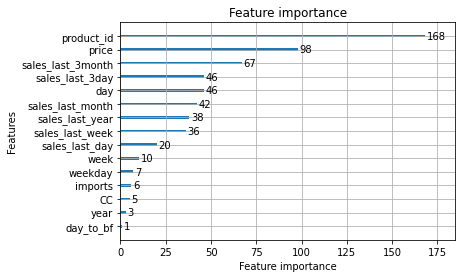

In [43]:
model = lgb.Booster(model_file='model.txt')
ax = lgb.plot_importance(model)
ax.figure.savefig('feature_importance.jpg')

### 5. Price elasticity of demand<a name="evaluation_5"></a>

Lastly in the evaluation section, price elasticity of demand is investigated. <br>

We replicate the feature of a specific product on a specific day with different prices, and compare the demand forecast. <br>

Inspection of price elasticity of demand is important because it provides insights on price optimization.<br>
For example, if the prediction of sales largely changes within small range of prices, the demand of the product may be sensitive to a small price change. That means companies should be careful when they change the prices of the product. Too much price change might result in a failure in maximizing the profit.<br>



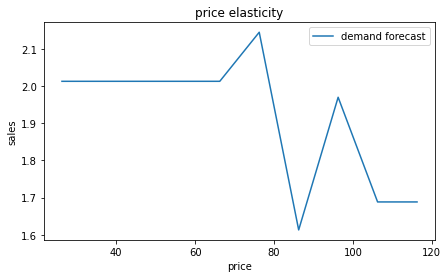

In [117]:
# create features with different prices.
# 1. copy the feature of product_id='e53e557d5a159f5aa2c5e995dfdf244b' on eval_date.
_tmp_elasticity = df[df.date==eval_date]
_tmp_elasticity = _tmp_elasticity[_tmp_elasticity.product_id=='e53e557d5a159f5aa2c5e995dfdf244b'].reset_index(drop=True)

# 2. replicate the feature and update the prices.
base_price = _tmp_elasticity.price[0]
prices = np.arange(base_price-50, base_price+50, 10)
_tmp_elasticity = pd.concat([_tmp_elasticity]*len(prices))
_tmp_elasticity['price'] = prices

# predict the demand volume
model = lgb.Booster(model_file='model.txt')
y = model.predict(_tmp_elasticity.drop(['date','sales'],axis=1))

# plot
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.plot(prices, y, label='demand forecast')
ax.set_xlabel('price')
ax.set_ylabel('sales')
ax.legend(loc='upper right')
ax.title.set_text('price elasticity')
# plt.savefig('price_elasticity.jpg'.format(_items[i]))
plt.show()

It seems that the model tells us that lower prices under 65 may result in higher demand, while higher prices over 110 may result in lower demand. However, predictions between the prices of 65 and 110 are too noisy and the model fails to predict the sales volume in this range. <br>
This means that this model is not expressive enough to catch the price elasticity of demand, because this product has a history of price changes only within 78 to 110 as we can see in the demand forecasting curve in the previous section ([section 4-2-1](#evaluation_2)).<br><br>
Therefore, we need more historical data as well as more accurate model to discuss the elasticity of price.


## Conclusion<a name="#conclusion"></a>
---

As a summary, a simple case study of demand forecasting has been shown in this work.<br> 

Although we have very limited data, the model predicts some trends in the demand history. For example, the result in [section 4-2](#evaluation_2) shows that the model successfully predicts some of the main peaks in the demand history of a specific product (4 big peaks in January, February, and March 2018). It also catches some trends of the average demand curve. <br>

At this time we ignored the "olist_items" dataset, which contains detailed information about products (size, picture, and reviews from customers), but further feature engineering and integrations of these data will improve the demand forecasting model. Moreover, additional information such as details of stores, competition, weather, special events or holidays, other macroeconomic variables, operating costs will improve the performance of the model.<br>

As a future work, inspections of price elasticity of demand should be meaningful for further exploration. Although our analyses in [section 4-5](#evaluation_5) shows we need more data to obtain equitable prediction results, our work showed a very simple example of the idea of price optimization.<br><br>


Thank you for reading this article. I appriciate any comments, questions, and suggestions.<br><br>

